# Sentiment Analysis
In this notebook we perform the sentiment analysis for individual datasets, such as single episodes for Wandavision, or YouTube comments from films (also for Reddit and IMDB). Hence, we have run this code for every single dataset extracted from each resource (Twitter for Wandavision, YouTube, Reddit and IMDB for the film analysis). Here we execute a single one. Also, it is commented considering the particular results of the episode analyzed. It is important to remark that for some particular cells, such as the TF or TF-IDF, the code was provided in the course, and may be highly simmilar as only small changes have been applied, due to the fact that it already covered our necessities.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

Here, depending on the file format of the dataset, we load it one way or another. For instance, all datasets from Wandavision are in .jsonl format, whilst the rest (YouTube, Reddit and IMDB) are in csv.

In [2]:
import pandas as pd
import json

JSON = True

# If JSONL type
if JSON:
  with open('/content/drive/Shareddrives/WebIntelligence/DATA/Twitter/wandavision_12FEB.jsonl') as f:
      lines = f.read().splitlines()
  df_inter  = pd.DataFrame(lines)
  df_inter .columns = ['json_element']    
  df_inter ['json_element'].apply(json.loads)
  df = pd.json_normalize(df_inter['json_element'].apply(json.loads))
  # Keep only the tweets in English
  df = df[df.lang=='en']
  # Create URL field for tweets
  df['url'] = 'https://twitter.com/_/status/'+df['id_str']

else:
  df = pd.read_csv('/content/drive/Shareddrives/WebIntelligence/DATA/IMDB/irish_imdb.csv')

In [3]:
df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,user.id,user.id_str,user.name,user.screen_name,user.location,user.url,user.description,user.translator_type,user.protected,user.verified,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,...,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.filter_level,retweeted_status.quoted_status.lang,retweeted_status.quoted_status_permalink.url,retweeted_status.quoted_status_permalink.expanded,retweeted_status.quoted_status_permalink.display,retweeted_status.place.id,retweeted_status.place.url,retweeted_status.place.place_type,retweeted_status.place.name,retweeted_status.place.full_name,retweeted_status.place.country_code,retweeted_status.place.country,retweeted_status.place.bounding_box.type,retweeted_status.place.bounding_box.coordinates,retweeted_status.scopes.followers,retweeted_status.quoted_status.extended_tweet.full_text,retweeted_status.quoted_status.extended_tweet.display_text_range,retweeted_status.quoted_status.extended_tweet.entities.hashtags,retweeted_status.quoted_status.extended_tweet.entities.urls,retweeted_status.quoted_status.extended_tweet.entities.user_mentions,retweeted_status.quoted_status.extended_tweet.entities.symbols,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str,retweeted_status.quoted_status.extended_tweet.entities.media,retweeted_status.quoted_status.extended_tweet.extended_entities.media,withheld_in_countries,quoted_status.place.id,quoted_status.place.url,quoted_status.place.place_type,quoted_status.place.name,quoted_status.place.full_name,quoted_status.place.country_code,quoted_status.place.country,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,retweeted_status.quoted_status.scopes.followers,url
0,Fri Feb 12 16:52:55 +0000 2021,1360270672400764929,1360270672400764929,#WandaVision #BiaKicisNaCCJSim #BiaKicisNaCCJS...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775564,1046110666304573440,1046110666304573440,Anik islam,Anik32671634,tangail.,None,I'm a Webdesigner and developer!,none,False,False,509,1511,0,163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270672400764929
1,Fri Feb 12 16:52:55 +0000 2021,1360270673227247629,1360270673227247629,RT @NACHO2813: Me when this pops up on the scr...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775761,1165292957429354498,1165292957429354498,🤷🏽‍♀️,HeavenWells,"Louisville, KY",None,BLESSED.,none,False,False,27,43,0,164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270673227247629
2,Fri Feb 12 16:52:55 +0000 2021,1360270673432698884,1360270673432698884,RT @itsjustanx: NEW #WandaVision Halloween the...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,NaN,low,en,1613148775810,925190433722044416,925190433722044416,alanis 🌞,alanisymr03,None,None,"hey, i love harry",none,False,False,47,92,0,5073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270

In [4]:
df.shape

(3000, 361)

The following code just makes the review column have the same name as in other platforms such as YouTube or Reddit, because the IMDB dataset has the review text in a column named "review".

In [5]:
if 'review' in df.columns:
  df.rename(columns={'review': 'text'}, inplace=True)

df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,user.id,user.id_str,user.name,user.screen_name,user.location,user.url,user.description,user.translator_type,user.protected,user.verified,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,...,retweeted_status.quoted_status.favorited,retweeted_status.quoted_status.retweeted,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.filter_level,retweeted_status.quoted_status.lang,retweeted_status.quoted_status_permalink.url,retweeted_status.quoted_status_permalink.expanded,retweeted_status.quoted_status_permalink.display,retweeted_status.place.id,retweeted_status.place.url,retweeted_status.place.place_type,retweeted_status.place.name,retweeted_status.place.full_name,retweeted_status.place.country_code,retweeted_status.place.country,retweeted_status.place.bounding_box.type,retweeted_status.place.bounding_box.coordinates,retweeted_status.scopes.followers,retweeted_status.quoted_status.extended_tweet.full_text,retweeted_status.quoted_status.extended_tweet.display_text_range,retweeted_status.quoted_status.extended_tweet.entities.hashtags,retweeted_status.quoted_status.extended_tweet.entities.urls,retweeted_status.quoted_status.extended_tweet.entities.user_mentions,retweeted_status.quoted_status.extended_tweet.entities.symbols,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str,retweeted_status.quoted_status.extended_tweet.entities.media,retweeted_status.quoted_status.extended_tweet.extended_entities.media,withheld_in_countries,quoted_status.place.id,quoted_status.place.url,quoted_status.place.place_type,quoted_status.place.name,quoted_status.place.full_name,quoted_status.place.country_code,quoted_status.place.country,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,retweeted_status.quoted_status.scopes.followers,url
0,Fri Feb 12 16:52:55 +0000 2021,1360270672400764929,1360270672400764929,#WandaVision #BiaKicisNaCCJSim #BiaKicisNaCCJS...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775564,1046110666304573440,1046110666304573440,Anik islam,Anik32671634,tangail.,None,I'm a Webdesigner and developer!,none,False,False,509,1511,0,163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270672400764929
1,Fri Feb 12 16:52:55 +0000 2021,1360270673227247629,1360270673227247629,RT @NACHO2813: Me when this pops up on the scr...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775761,1165292957429354498,1165292957429354498,🤷🏽‍♀️,HeavenWells,"Louisville, KY",None,BLESSED.,none,False,False,27,43,0,164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270673227247629
2,Fri Feb 12 16:52:55 +0000 2021,1360270673432698884,1360270673432698884,RT @itsjustanx: NEW #WandaVision Halloween the...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,NaN,low,en,1613148775810,925190433722044416,925190433722044416,alanis 🌞,alanisymr03,None,None,"hey, i love harry",none,False,False,47,92,0,5073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270

## Compute Term frequency
First we clean the text with the default stopword, plus some we have found to be irrelevant such as "Co", "https" or "RT". Afterwards we directly compute the term frequency.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


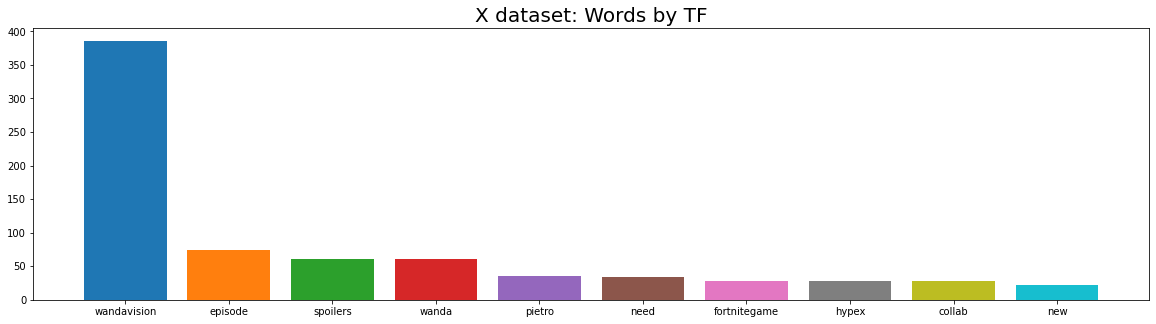

In [6]:
import nltk
import matplotlib.pyplot as plt 
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
nltk.download('stopwords')

# Extract tokens, generate count vectors and remove stopwords
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
word_vec = df['text'].apply(str.lower).apply(tokenizer.tokenize).apply(pd.value_counts).fillna(0)
word_vec = word_vec.drop(stopwords.words('english')+['https','co', 'rt'], axis=1, errors='ignore').fillna(0)

# Compute term frequencies
tf = word_vec.divide(np.sum(word_vec, axis=1), axis=0)
tf_dict = {}

for column in tf:  
  tf_dict[column] = tf[column].sum()
tf_words = sorted(tf_dict.items(), key=lambda item: item[1], reverse=True)[:10]

labels  = [w[0] for w in tf_words]
values  = [w[1] for w in tf_words]
indexes = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(20,5))
cmap = plt.cm.tab10
plt.bar(indexes, values, color=cmap(np.arange(len(df)) % cmap.N))
plt.xticks(indexes, labels)
plt.title('X dataset: Words by TF', fontsize=20)
plt.show()

As it was expected, "wandavision" is the most frequent word in all the tweets, as it could be found in hashtags, outside them, but if people is referring to the TV show, they probably mention this word. Also, in this chapter a new (and marvel loved) character appeared; Pietro, the twin of Wanda. That is the reason why it appears in this rank. Summarizing, all the words here make sense.

## TF-IDF

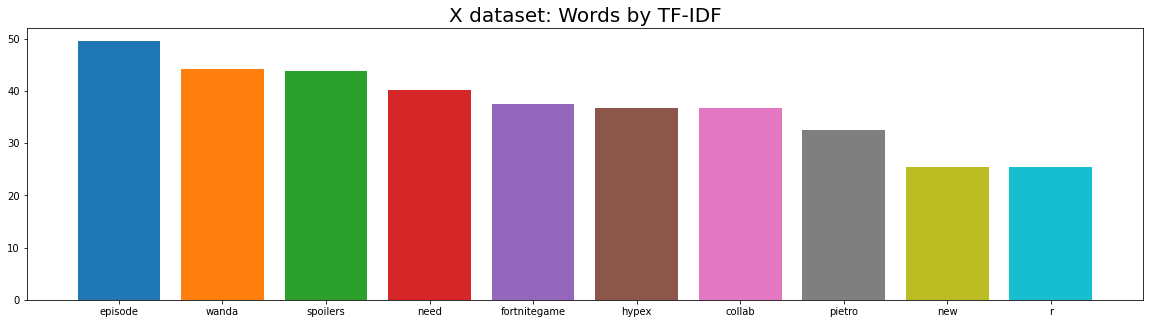

In [7]:
# Compute inverse document frequencies
idf = np.log10(len(tf) / word_vec[word_vec > 0].count())

# Compute TF-IDF vectors
tfidf = np.multiply(tf, idf.to_frame().T)
tfidf_dict = {}

for column in tfidf:  
  tfidf_dict[column] = tfidf[column].sum()
tfidf_words = sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)[:10]

labels  = [w[0] for w in tfidf_words]
values  = [w[1] for w in tfidf_words]
indexes = np.arange(len(labels))

f, ax = plt.subplots(figsize=(20,5))
cmap = plt.cm.tab10
plt.bar(indexes, values, color=cmap(np.arange(len(df)) % cmap.N))
plt.xticks(indexes, labels)
plt.title('X dataset: Words by TF-IDF', fontsize=20)
plt.show()

As we can see in the TF-IDF figure, some of the most relevant words could be expected. Also, the previous "leader" of the rank, "wandavision" is not here anymore. Wanda, the main character of the TV show, spoilers, one of the most common fears of the society, or episode, to refer the episode they are talking about. Nevertheless, some of the words such as hypex, or pietro are strictly related to that particular episode. 



We wanted to perform TF and TF-IDF to ensure that the words appearing in these rankings made sense, and also to discover if there was a highly relevant word that, at first sight we might not think about, such as a generalized opinion. 

## VADER scores

In [8]:
from collections import Counter 
# Initialize the VADER sentiment analyzer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
counter = Counter(sid.lexicon) 
# Compute VADER scores
df['scores'] = df['text'].apply(lambda text: sid.polarity_scores(text))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >0 else 'neg' if c <0 else 'neu')
# df[['url','text','scores','compound','comp_score']].head(20)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Metrics computations

Using the VADER scores, and also the text properties themselves such as the tweet length, we compute the metrics that will serve as analysis of this part of the project; the evaluation of Wandavision along the different episodes. This code will perform the metrics for a single episode. The results of the evolution are reported in the corresponding notebook, linked in the main one.

In [9]:
df.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,user.id,user.id_str,user.name,user.screen_name,user.location,user.url,user.description,user.translator_type,user.protected,user.verified,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,...,retweeted_status.quoted_status.filter_level,retweeted_status.quoted_status.lang,retweeted_status.quoted_status_permalink.url,retweeted_status.quoted_status_permalink.expanded,retweeted_status.quoted_status_permalink.display,retweeted_status.place.id,retweeted_status.place.url,retweeted_status.place.place_type,retweeted_status.place.name,retweeted_status.place.full_name,retweeted_status.place.country_code,retweeted_status.place.country,retweeted_status.place.bounding_box.type,retweeted_status.place.bounding_box.coordinates,retweeted_status.scopes.followers,retweeted_status.quoted_status.extended_tweet.full_text,retweeted_status.quoted_status.extended_tweet.display_text_range,retweeted_status.quoted_status.extended_tweet.entities.hashtags,retweeted_status.quoted_status.extended_tweet.entities.urls,retweeted_status.quoted_status.extended_tweet.entities.user_mentions,retweeted_status.quoted_status.extended_tweet.entities.symbols,quoted_status.quoted_status_id,quoted_status.quoted_status_id_str,retweeted_status.quoted_status.extended_tweet.entities.media,retweeted_status.quoted_status.extended_tweet.extended_entities.media,withheld_in_countries,quoted_status.place.id,quoted_status.place.url,quoted_status.place.place_type,quoted_status.place.name,quoted_status.place.full_name,quoted_status.place.country_code,quoted_status.place.country,quoted_status.place.bounding_box.type,quoted_status.place.bounding_box.coordinates,retweeted_status.quoted_status.scopes.followers,url,scores,compound,comp_score
0,Fri Feb 12 16:52:55 +0000 2021,1360270672400764929,1360270672400764929,#WandaVision #BiaKicisNaCCJSim #BiaKicisNaCCJS...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775564,1046110666304573440,1046110666304573440,Anik islam,Anik32671634,tangail.,None,I'm a Webdesigner and developer!,none,False,False,509,1511,0,163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270672400764929,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
1,Fri Feb 12 16:52:55 +0000 2021,1360270673227247629,1360270673227247629,RT @NACHO2813: Me when this pops up on the scr...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,False,low,en,1613148775761,1165292957429354498,1165292957429354498,🤷🏽‍♀️,HeavenWells,"Louisville, KY",None,BLESSED.,none,False,False,27,43,0,164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270673227247629,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,neu
2,Fri Feb 12 16:52:55 +0000 2021,1360270673432698884,1360270673432698884,RT @itsjustanx: NEW #WandaVision Halloween the...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,None,None,None,None,NaN,None,False,0,0,0,0,False,False,NaN,low,en,1613148775810,925190433722044416,925190433722044416,alanis 🌞,alanisymr03,None,None,"hey, i love harry",none,False,False,47,92,0,5073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://twitter.com/_/status/1360270673432698884,"{'neg':

The following code basically counts how many tweets have an overall positive, negative or neutral compound value. This will be relevant in the analysis to understand better the general acceptance of each episode.

In [10]:
metrics = df.groupby(by='comp_score').count()
pos = metrics['scores']['pos']
neg = metrics['scores']['neg']
neu = metrics['scores']['neu']
print('#Positive tweets: ', pos)
print('#Negative tweets: ', neg)
print('#Neutral tweets: ', neu)

#Positive tweets:  1044
#Negative tweets:  510
#Neutral tweets:  1446


For this particular episode, we can observe that there are twice as many positive tweets as negative. It is also relevant that the number of neutral tweets is bigger than both, with denotes a general neutraity (due to neutral words, or not know words by VADER such LOL or other acronyms/slang words).

In [11]:
mean = df['compound'].mean()
variance = df['compound'].var()
print('Mean: ', mean)
print('Variance: ', variance)

Mean:  0.09150106666666655
Variance:  0.14136228374010754


Also, in this code above we computed the mean compound value for all the tweets. Again, this supports the general acceptance analysis. For this specific episode, we see a relatively low compound value, probably affected by the high neutral tweets, and not that much for the negative. Despite that, the episode had a positive impact.

The last computed metrics for each episode are the mean number of positive and negative words per tweet, as it may explain some of the previous results.  

In [12]:
def count_words(full_text, only_count, polarity):
  token_full = tokenizer.tokenize(full_text)
  
  if only_count:
    return len(token_full)

  n_pos_words = 0
  for word in token_full:
    score = sid.polarity_scores(word)
    if polarity:
      if score['compound'] > 0:
        n_pos_words = n_pos_words + 1 
    else:
      if score['compound'] < 0:
        n_pos_words = n_pos_words + 1 
  
  return n_pos_words

df['num_positive_words'] = df['text'].apply(lambda x: count_words(x, False, True) )
df['num_negative_words'] = df['text'].apply(lambda x: count_words(x, False, False) )
df['num_words'] = df['text'].apply(lambda x: count_words(x, True, False) )

In [13]:
pos_word_mean = df['num_positive_words'].mean()
pos_word_var = df['num_positive_words'].var()
neg_word_mean = df['num_negative_words'].mean()
neg_word_var = df['num_negative_words'].var()
n_words_mean = df['num_words'].mean()
n_words_var = df['num_words'].var()
print('Mean of positive words per tweet: ',pos_word_mean)
print('Variance of positive words per tweet: ',pos_word_var)
print('Mean of negative words per tweet: ',neg_word_mean)
print('Variance of negative words per tweet: ',neg_word_var)
print('Mean of words per tweet: ',n_words_mean)
print('Variance of words per tweet: ',n_words_var)

Mean of positive words per tweet:  0.609
Variance of positive words per tweet:  0.6630066688896425
Mean of negative words per tweet:  0.311
Variance of negative words per tweet:  0.3450606868956357
Mean of words per tweet:  16.105666666666668
Variance of words per tweet:  39.837113593419886


Supporting the first metric, where the positive tweets were twice the number of negatives, in this case we see a really low value of positive words per tweet (in fact, less than one), but it is still twice the number of negative words per tweet. We should remark that in Twitter, the coments don't use to be really extended (by the type of platform, and y the character constraint). The mean of words per tweet is 16, which it stills makes 0.6 positive words per tweet a really low value. In the overall analysis we'll see if this is a general pattern or it's just a fact of this episode.

##Wordclouds representations 

Now, we wanted to visualize in Wordclouds the most common words in the data collected, plus identify them by the polarity considering 2 approaches. 

In [14]:
!pip install wordcloud

The first step was to separate the tweets by its compound value, to be able to identify words in positive, negative or in both kind of tweets. Also, we carried out a seccond approach: instead of considering positive words those which appeared in positive tweets, we treated the words independently. At the end of this section we'll observe the differences.

In [15]:
# From the dataframe scores (VADER scores), get positive and negative words
def getNegPosWords(df):
  pos_list = []
  neg_list = []
  for index,row in df.iterrows():
    score = row['compound']
    text = row['text']
    if score<0:
      neg_list.append(text)
    if score>0:
      pos_list.append(text)
  
  return pos_list, neg_list

# returns the LIST cleaned
def createCleanedText(list_):
  text = ''
  for k in list_:
    text = k + ' ' + text

  replace_words = ['rt', 'https', "wanda", "wandavision", "will"]
  # replace_words = ['rt', 'https', "wanda", "wandavision", "review"]
  text = text.lower()
  for r in replace_words:
    text = text.replace(r, ' ')

  words = tokenizer.tokenize(text)
  return words, text

# If a word exists in both, positive and negative, we consider it neutral
def getNeutralWords(pos_list, neg_list):
  neutral_words = []
  for w in neg_list:
    if w in pos_list:
      neutral_words.append(w)
  neutral_words = np.unique(neutral_words)
  return neutral_words

# Delete neutral words form the positive and negative lists
def updateListFromNeutralW(neutral_w, pos_list, neg_list):
  for j in neutral_w:
    neg_list = np.delete(neg_list,np.where(neg_list==j))
    pos_list = np.delete(pos_list,np.where(pos_list==j))
  return pos_list, neg_list

# consider positive word only bi its compound, not the tweet
def secondApproach(full_text):
  token_full = tokenizer.tokenize(full_text)
  words_p = []
  words_n = []
  words_neu = []
  for word in token_full:
    score = sid.polarity_scores(word)
    if score['compound']>0:
      words_p.append(word)
    elif score['compound'] < 0:
      words_n.append(word)
    else:
      words_neu.append(word)
  return words_p, words_n, words_neu

positive_doc, negative_doc = getNegPosWords(df)

# Episode X
words_p, text_p = createCleanedText(positive_doc) 
words_n, text_n = createCleanedText(negative_doc) 
neutral_w = getNeutralWords(words_p, words_n)
full_text = text_p + ' ' + text_n
words_p, words_n = updateListFromNeutralW(neutral_w, words_p, words_n)
# Episode X: second approach
words_p_2, words_n_2, neutral_w_2 = secondApproach(full_text) 


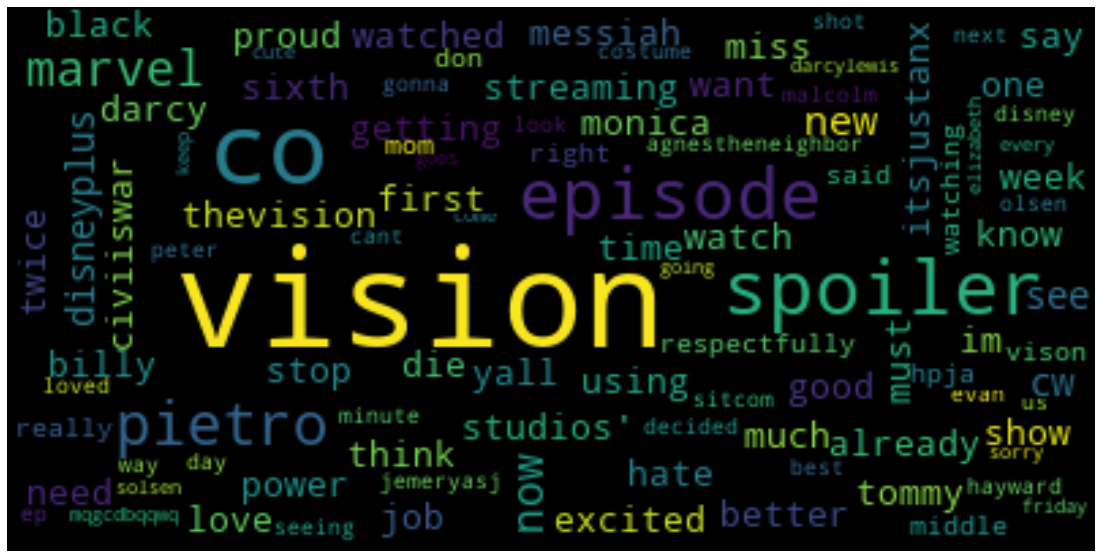

In [16]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

# Wordcloud for Episode 3
wordcloud = WordCloud(collocations=False,max_font_size=50,min_font_size=7,max_words=100, background_color="black").generate(full_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


This represents only the most common words visualized in a Wordcloud. As we have already seen in the TF and TF-IDF, some words such as "Vision", "episode" or "pietro" are the most popular ones. 

### Recoloring WordCloud by tweet score (not individual word)

This is the first approach to visualize the polarity of the most common words. We consider positive (green) words those appearing in the positive tweets, and negative (red) for those appearing in the negative ones. First, we define a method which create a mapping for postive and negative words. This method will be used in the forthcoming cell.

In [17]:
from wordcloud import (WordCloud, get_single_color_func)
class GroupedColorFunc(object):
    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


Here we recolor the wordcloud and also we transform the wordcloud mask to a Twitter bird, just for visualization purposes as we extracted all the data from there. 

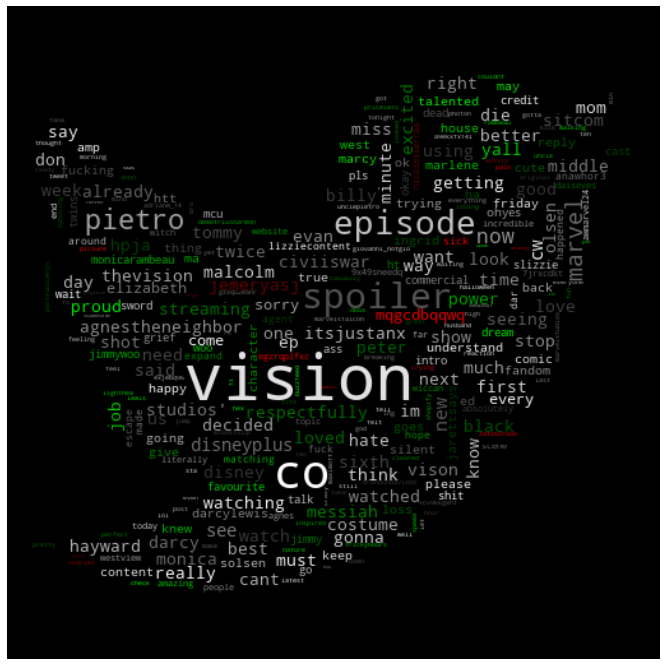

In [18]:
from PIL import Image 
cloud_mask = np.array(Image.open("/content/drive/Shareddrives/WebIntelligence/STABLE/mask.png"))

def transform_format(val):
  if val == 0:
    return 255
  else:
    return val

transformed_cloud_mask = np.ndarray((cloud_mask.shape[0],cloud_mask.shape[1]), np.int32)
for i in range(len(cloud_mask)):
    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))

wordcloud_cloud1 = WordCloud(collocations=False,max_font_size=50,min_font_size=5,
                            max_words=300, background_color="black",
                            mask=transformed_cloud_mask,).generate(full_text)
color_to_words = {
    # words below will be colored with a green single color function
    'green': words_p,
    # will be colored with a red single color function
    'red': words_n
}
# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'white'

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud_cloud1.recolor(color_func=grouped_color_func)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_cloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('/content/drive/Shareddrives/WebIntelligence/DATA//IMAGES/wandavision_ep6_recolor1.jpg')

In the Wordcloud above we can see that the majority of words are treated as neutral. This is because almost all of them appeared in both, positive and negative tweets, and for this approach, we considered words that appeared in both sentiments as neutral. Despite that constraint, we can see that some words only appreared in one single "sentiment", such as proud, loved or excited for positive tweets, and jemeryasj for negative ones. This las one is a Twitter username, which probably made some mistake spoiling people, or gave an unpopular opinion.

### Recoloring based on individual word scoring over positive and negative scored tweets/docs

As previously mentioned, this seccond aproach takes into account each word individually to know if it belongs to the positive or negative recoloring list.

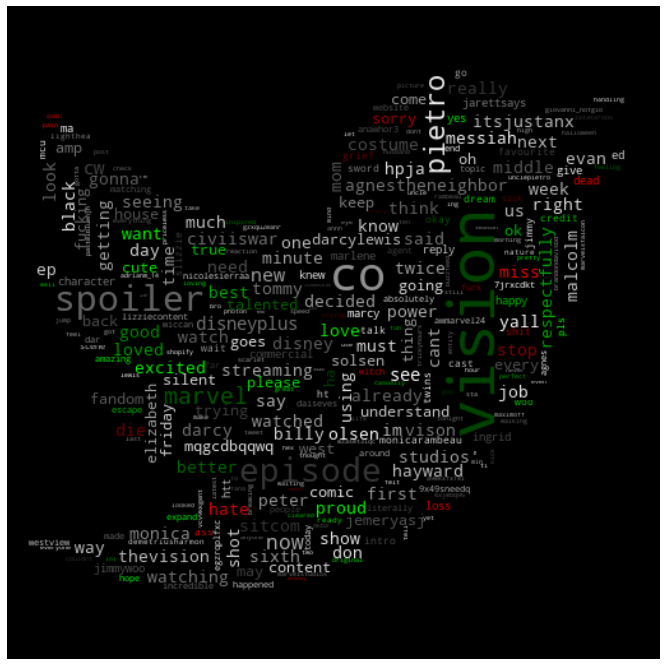

In [20]:
from PIL import Image 
cloud_mask = np.array(Image.open("/content/drive/Shareddrives/WebIntelligence/STABLE/mask.png"))

def transform_format(val):
  if val == 0:
    return 255
  else:
    return val

transformed_cloud_mask = np.ndarray((cloud_mask.shape[0],cloud_mask.shape[1]), np.int32)
for i in range(len(cloud_mask)):
    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))

wordcloud_cloud = WordCloud(collocations=False,max_font_size=50,min_font_size=5,
                            max_words=300, background_color="black",
                            mask=transformed_cloud_mask,).generate(full_text)
color_to_words_2 = {
    'green': words_p_2,
    'red': words_n_2
}
grouped_color_func_2 = GroupedColorFunc(color_to_words_2, default_color)

# Apply our color function
wordcloud_cloud.recolor(color_func=grouped_color_func_2)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('/content/drive/Shareddrives/WebIntelligence/DATA//IMAGES/wandavision_ep6_recolor2.jpg')

This time we see more words of both polarities, and they depend directly on their inner meaning, such as die, miss or hate for negative words, or marvel (not the company, but the verb), good, proud, best... for the positive. For some reason, vision is considered by VADER as a positive word.